## Cortical Activity of Evaluation
This notebook compares averaging cortical activity of evaluation dataset (one prediction for all subjects) vs individual cortical data

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt

In [39]:
def heatmap_annotate(df_to_plot, ds_order, ax, ds_order_y=None, column=['train_dataset'], row=['eval_dataset'], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.5):
    if ds_order_y is None:
        if 'Fusion' in ds_order:
            ds_order_y = [ds for ds in ds_order if ds!='Fusion']
        else:
            ds_order_y = ds_order
    V = pd.pivot_table(df_to_plot, columns=column, index=row, values=value)
    V = V.reindex(ds_order_y, axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    sns.heatmap(V.values, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, square=True, ax=ax)
    if 'Fusion' in ds_order:
        ax.axvline(len(ds_order_y), color='k', linewidth=2)

    return ax

### Loading avg and loo models

In [42]:
method = 'L2reg'
train_ds_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]#, "Fusion"]
eval_ds_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
df_all = pd.DataFrame()
for dataset_name in train_ds_list:
    eval_data = [ev_ds if ev_ds != "Language" else "Languagelocalizer" for ev_ds in eval_ds_list]
    eval_data = [ev_ds if ev_ds != "HCPur100" else "HCPur100task" for ev_ds in eval_data]

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg-Cavg"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    df = rm.comb_eval(models=[dataset_name+"-avg-Cind"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo-Cavg"],methods=[method],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer'],cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    df = rm.comb_eval(models=[dataset_name+"-loo-Cind"],methods=[method],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer'],cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

df_cortical_avg = df_all[df_all.cortical_act == 'avg'].reset_index(drop=True)
df_cortical_ind = df_all[df_all.cortical_act == 'ind'].reset_index(drop=True)

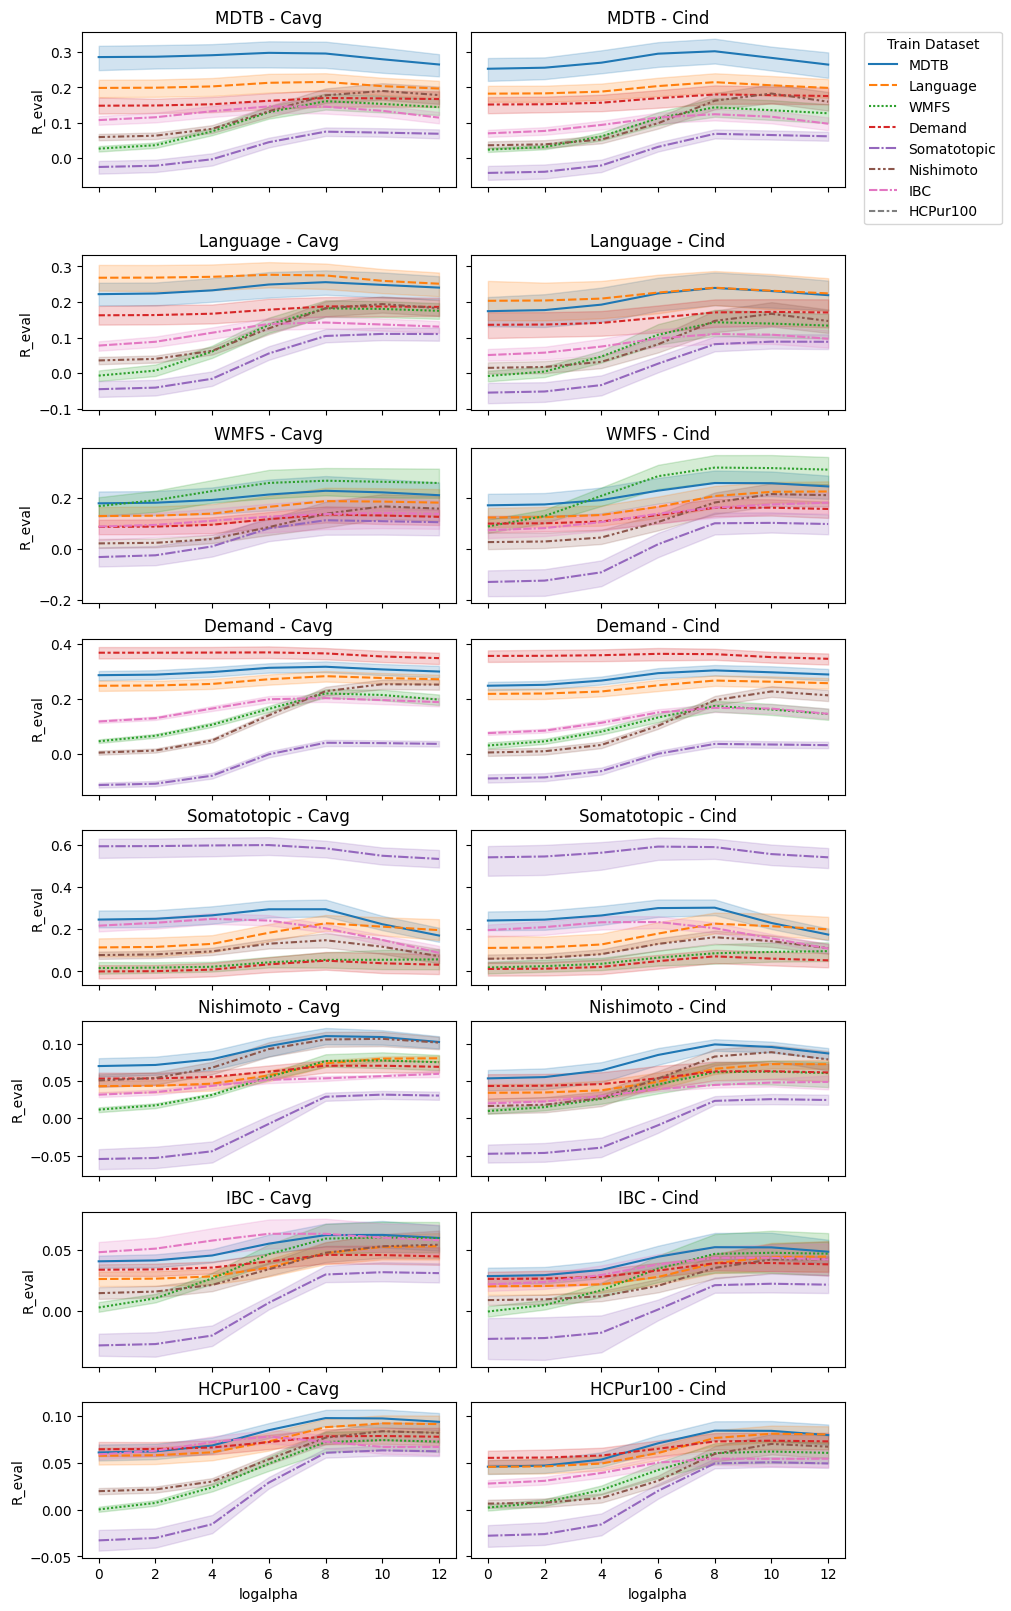

In [43]:
fig, axes = plt.subplots(len(eval_ds_list), 2, figsize=(10, 16), sharey='row', sharex='col', constrained_layout=True)
for i,ed in enumerate(eval_ds_list):
    # Left subplot
    ax_cavg = axes[i, 0]
    df_to_plot = df_cortical_avg[(df_cortical_avg.eval_dataset==ed) & ((df_cortical_avg.train_dataset!=ed)
                                                                       | (df_cortical_avg.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=eval_ds_list, style_order=eval_ds_list, legend=False, ax=ax_cavg)
    ax_cavg.set_title(f'{ed} - Cavg')

    # Right subplot
    ax_cind = axes[i, 1]
    df_to_plot = df_cortical_ind[(df_cortical_ind.eval_dataset==ed) & ((df_cortical_ind.train_dataset!=ed)
                                                                       | (df_cortical_ind.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=eval_ds_list, style_order=eval_ds_list, ax=ax_cind)
    ax_cind.set_title(f'{ed} - Cind')

    if i == 0:
        ax_cind.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Train Dataset')
    else:
        ax_cind.legend_.remove()

### Find best hyperparameter

In [44]:
# cortical avg
A = pd.pivot_table(df_cortical_avg, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_cortical_avg['isbest'] = df_cortical_avg.logalpha.values == bestla.loc[df_cortical_avg.train_dataset].values.flatten()

# cortical ind
A = pd.pivot_table(df_cortical_ind, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_cortical_ind['isbest'] = df_cortical_ind.logalpha.values == bestla.loc[df_cortical_ind.train_dataset].values.flatten()

# Create a subset for best logalpha values
df_avg_best = df_cortical_avg[df_cortical_avg.isbest]
df_ind_best = df_cortical_ind[df_cortical_ind.isbest]

R_eval                                                    \
logalpha           0.0       2.0       4.0       6.0       8.0       10.0   
train_dataset                                                               
MDTB           0.176538  0.178115  0.185834  0.201300  0.208682  0.199458   
Language       0.146577  0.147325  0.151919  0.166916  0.179635  0.175839   
WMFS           0.030376  0.042541  0.072221  0.113583  0.144711  0.142535   
Demand         0.148568  0.149011  0.151665  0.159867  0.166168  0.162658   
Somatotopic   -0.021149 -0.017601  0.002381  0.056237  0.089042  0.087926   
Nishimoto      0.027403  0.031129  0.049526  0.097577  0.142619  0.154718   
IBC            0.089001  0.096536  0.115025  0.130330  0.129146  0.121430   

                         
logalpha           12.0  
train_dataset            
MDTB           0.189875  
Language       0.171766  
WMFS           0.136141  
Demand         0.159781  
Somatotopic    0.085368  
Nishimoto      0.148087  
IBC            0.113248

,best_logalpha
train_dataset,
MDTB,8.0
Language,8.0
WMFS,8.0
Demand,8.0
Somatotopic,8.0
Nishimoto,10.0
IBC,6.0


R_eval                                                    \
logalpha           0.0       2.0       4.0       6.0       8.0       10.0   
train_dataset                                                               
MDTB           0.151899  0.154315  0.166249  0.190573  0.203256  0.194547   
Language       0.126495  0.127369  0.132772  0.151115  0.170184  0.170071   
WMFS           0.019422  0.031324  0.060564  0.101993  0.129872  0.126209   
Demand         0.142012  0.142583  0.146006  0.156818  0.166341  0.163644   
Somatotopic   -0.028880 -0.025963 -0.009178  0.042657  0.079960  0.078831   
Nishimoto      0.016281  0.018649  0.031276  0.072702  0.127824  0.145691   
IBC            0.058086  0.064177  0.080945  0.101739  0.110601  0.107789   

                         
logalpha           12.0  
train_dataset            
MDTB           0.183306  
Language       0.166348  
WMFS           0.119928  
Demand         0.160589  
Somatotopic    0.076169  
Nishimoto      0.134158  
IBC            0.098079

,best_logalpha
train_dataset,
MDTB,8.0
Language,8.0
WMFS,8.0
Demand,8.0
Somatotopic,8.0
Nishimoto,10.0
IBC,8.0


### Evaluation Heatmap at best Hyperparameter

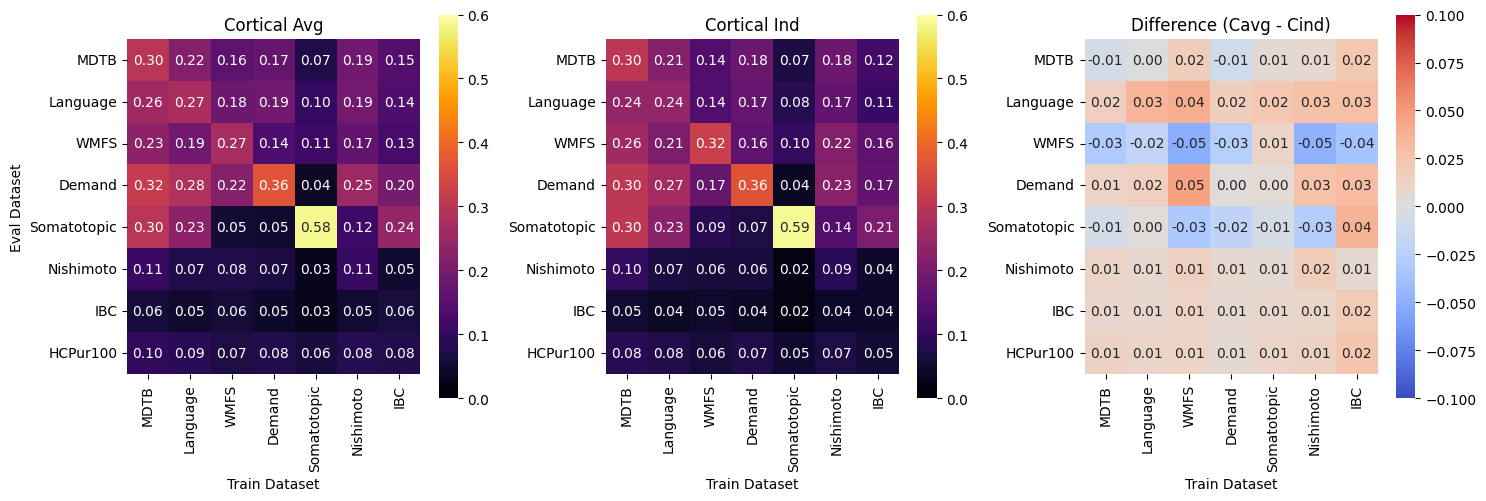

In [45]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

ax = heatmap_annotate(df_avg_best, ds_order=train_ds_list, ds_order_y=eval_ds_list, ax=axes[0], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.6)
ax.set_title('Cortical Avg')
ax.set_xlabel('Train Dataset')
ax.set_ylabel('Eval Dataset')

ax = heatmap_annotate(df_ind_best, ds_order=train_ds_list, ds_order_y=eval_ds_list, ax=axes[1], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.6)
ax.set_title('Cortical Ind')
ax.set_xlabel('Train Dataset')

# Calculate the difference in 'R_eval' for the same group of (train_dataset, eval_dataset, eval_subj)
df_diff = pd.merge(df_avg_best[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   df_ind_best[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   on=['train_dataset', 'eval_dataset', 'eval_subj'],
                   suffixes=('_Cavg', '_Cind'))

df_diff['R_eval_diff'] = df_diff['R_eval_Cavg'] - df_diff['R_eval_Cind']
ax = heatmap_annotate(df_diff, ds_order=train_ds_list, ds_order_y=eval_ds_list, ax=axes[2], value=['R_eval_diff'], cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax.set_title('Difference (Cavg - Cind)')
ax.set_xlabel('Train Dataset')

plt.tight_layout()